In [1]:
import os
import argparse
import numpy as np
import pandas as pd
from scipy.stats import fisher_exact, chi2_contingency
from scipy.stats.contingency import odds_ratio
from scipy import stats
from functools import reduce
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

import sys
sys.path.append("../src")
import utils.parsing as utpa
import utils.plotting as utpl

# plotting
import os
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 14, 'axes.linewidth': 2, 'xtick.major.width': 1.5, 'xtick.major.size': 7, 'ytick.major.width': 1.5, 'ytick.major.size': 7})
from matplotlib.backends.backend_pdf import PdfPages
import forestplot as fp
import upsetplot

from scipy.stats import ttest_ind

In [2]:
def get_scaled_bmi(df, categorical_cols, numerical_cols, scaled_numerical_cols):
    # define encoders
    en = LabelEncoder()
    scaler = StandardScaler()
    # select the categorical and numerical columns
    # transform the categorical columns to integer values
    for cat_col in categorical_cols:
        df[cat_col] = en.fit_transform(df[cat_col])
    # scale the numerical columns
    df[numerical_cols] = scaler.fit_transform(df.loc[:, numerical_cols])
    # scale bmi separately
    df["bmi_scaled"] = scaler.fit_transform(df.loc[:, ["bmi"]])
    # Create the target variable (bmi_residuals) using linear regression
    X = df.loc[:, categorical_cols + numerical_cols + scaled_numerical_cols]
    y = df.loc[:, 'bmi_scaled']
    model = LinearRegression()
    model.fit(X, y)
    # save the residuals for bmi
    df['bmi_residuals'] = y - model.predict(X)
    return df

def create_bmi_res_prs_decile_data(phenotype_df):
    categorical_cols = ["genetic_sex"]
    numerical_cols = ["age"] + [f"genetic_pca{i}" for i in range(1, 40)]
    scaled_numerical_cols = []#["bmi_prs"]

    phenotype_df = get_scaled_bmi(phenotype_df, categorical_cols, numerical_cols, scaled_numerical_cols)
    phenotype_df["bmi_res_decile"] = pd.qcut(phenotype_df.bmi_residuals, q=10)
    phenotype_df["bmi_res_decile_num"] = pd.qcut(phenotype_df.bmi_residuals, q=10, labels=False)
    phenotype_df["bmi_prs_decile"] = pd.qcut(phenotype_df.bmi_prs, q=10)
    phenotype_df["bmi_prs_decile_num"] = pd.qcut(phenotype_df.bmi_prs, q=10, labels=False)
    phenotype_df["bmi_res_categories"] = phenotype_df.bmi_res_decile_num.map({
        0: "underweight", 
        1:"normal", 2:"normal", 
        3:"overweight", 4:"overweight", 5:"overweight", 6:"overweight", 7:"overweight",
        8:"obese", 9:"severe obesity"
        })
    phenotype_df["bmi_prs_categories"] = phenotype_df.bmi_prs_decile_num.map({
        0: "lowest", 
        1:"middle", 2:"middle", 
        3:"middle", 4:"middle", 5:"middle", 6:"middle", 7:"middle",
        8:"middle", 9:"highest"
        })
    mean_bmi_dict = phenotype_df.groupby("bmi_res_categories")["bmi"].mean().to_dict()
    return phenotype_df, mean_bmi_dict

def divide_into_nocomorbidity(features_df):
    no_comorbidity_df = features_df.loc[features_df.sum(axis=1)==0]
    comorbidity_df = features_df.loc[features_df.sum(axis=1)>0]
    return comorbidity_df, no_comorbidity_df

def cluster_by_comorbidity(features_df):
    comorbidity_df, no_comorbidity_df = divide_into_nocomorbidity(features_df)
    no_comorbidity_df["labels"] = 0

    X = comorbidity_df.values
    nclust = 2 #find_the_best_cluster(X)
    kmeans = KMeans(n_clusters=nclust, random_state=42, n_init="auto")
    y = kmeans.fit_predict(X)
    comorbidity_df["labels"] = y
    comorbidity_df["labels"] = comorbidity_df.labels.replace(0, nclust)
    icd_df = pd.concat((comorbidity_df, no_comorbidity_df))
    return icd_df.labels

def get_average_comorbidity_per_label(icd_features_df, comorbidity_labels):
    ncomorbidity_df = icd_features_df.sum(axis=1).to_frame()
    ncomorbidity_df.columns = ["ncomorbidity"]
    ncomorbidity_df = ncomorbidity_df.merge(comorbidity_labels, left_index=True, right_index=True).groupby("labels")["ncomorbidity"].mean()
    avg_comorbidities_per_label = ncomorbidity_df.to_dict()
    return avg_comorbidities_per_label

def get_rvas_gene(gene_file):
    with open(gene_file, "r") as f:
        genes = set([l.strip() for l in f.readlines()])
    return genes
    
def get_rvas_samples(rvas_studies, genotype_file):
    genotype_df = pd.read_csv(genotype_file)
    rvas_genes = reduce(lambda x,y: x.union(y), [get_rvas_gene(gf) for gf in rvas_studies])
    rvas_geno = genotype_df.loc[genotype_df.gene.isin(rvas_genes)]
    all_rvas_samples = set(",".join(rvas_geno.samples).split(","))
    return all_rvas_samples, rvas_geno

def add_carrier_info(phenotype_df, all_factor_samples):
    phenotype_df["carrier"] = phenotype_df.sample_names.isin(all_factor_samples)
    return phenotype_df

def create_phenotype_info_file(phenotype_samples_df, icd_features_df):
    comorbidity_labels = cluster_by_comorbidity(icd_features_df)
    avg_comorbidity_per_group = get_average_comorbidity_per_label(icd_features_df, comorbidity_labels)
    print(avg_comorbidity_per_group)
    phenotype_samples_info_df = phenotype_samples_df.loc[:, ["sample_names", "bmi", "bmi_prs", "bmi_residuals", "carrier", "bmi_res_categories", "bmi_prs_categories"]]
    phenotype_samples_info_df = phenotype_samples_info_df.merge(comorbidity_labels, left_on="sample_names", right_index=True)
    return phenotype_samples_info_df

def get_mean_bmi(samples, phenotype_samples_df):
    samples = set(samples.split(","))
    sample_pheno = phenotype_samples_df.loc[phenotype_samples_df.sample_names.isin(samples)]
    return pd.Series({"mean_bmi": sample_pheno.bmi.mean(), "mean_bmi_residuals": sample_pheno.bmi_residuals.mean(),})

def prepare_polynomial_features(data_df, features, y_var, include_bias):
    feature_df = data_df.loc[:, features].dropna()
    X = feature_df.values
    poly = PolynomialFeatures(len(features), interaction_only=True, include_bias=include_bias)
    X_poly = poly.fit_transform(X)
    y = data_df.loc[data_df.index.isin(feature_df.index), y_var].values.reshape(-1,1)
    return X_poly,y, poly.get_feature_names_out(input_features=features)[1:]

def train_model_sm(X, y):
    model = sm.OLS(y, X)
    results = model.fit()
    r2 = results.rsquared
    coefs = results.params[1:]
    conf_ints = results.conf_int()[1:]
    p_vals = results.pvalues[1:]
    return r2, coefs, conf_ints, p_vals

In [3]:
cohort_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz"
combo_files = [
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo2.csv",
    "/data6/deepro/ukb_bmi/3_characterization/data/combo_info/british/discovery_combo3.csv"
]
genotype_file = "/data6/deepro/ukb_bmi/0_data_preparation_and_download/exome_annot/data/processed_burden/all_gene_burden.csv.gz"
rvas_studies = [
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/akbari_2021/data/akbari_genes.list",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/turcot_2018/data/turcot_genes.list",
    "/data6/deepro/ukb_bmi/0_data_preparation_and_download/bmi_genes/marenne/data/marenne_genes.txt"
    ]
icd_feature_file = "/data6/deepro/ukb_bmi/3_characterization/data/bmi_pgs_comorbidity/british/discovery/obesity_related_comorbid_feature_file.csv.gz"

In [4]:
cohort_df = pd.read_csv(
    cohort_file, 
    usecols=["sample_names", "genetic_sex", "age"] + [f"genetic_pca{i}" for i in range(1, 40)] + ["bmi_prs", "bmi"])
cohort_df["sample_names"] = cohort_df.sample_names.astype(str)
combo_genes, combo_samples = utpa.get_combo_info_from_files(combo_files)
icd_features_df = pd.read_csv(icd_feature_file, index_col=0)
icd_features_df.index = icd_features_df.index.astype("str")
phenotype_samples_df, mean_bmi_dict = create_bmi_res_prs_decile_data(cohort_df)

In [5]:
rvas_samples, rvas_geno = get_rvas_samples(rvas_studies, genotype_file)
rvas_geno["nsamples"] = rvas_geno.samples.apply(lambda x: len(set(x.split(","))))
rvas_geno[["mean_bmi", "mean_bmi_residuals"]] = rvas_geno.samples.apply(get_mean_bmi, args=(phenotype_samples_df, ))

rvas_geno.sort_values("mean_bmi", ascending=False).head()

,gene,samples,nsamples,mean_bmi,mean_bmi_residuals
18013,ZMYM4,"2846330,3593291,3010118,5594034,1981233,572554...",15,31.217457,0.774211
9034,MC4R,"2039271,1856353,4677894,5333361,2735246,561935...",1217,29.160332,0.365044
17858,ZBTB7B,"4911244,5823981,1421062,5186724,1783208,337410...",22,28.847165,0.258680
12841,RAB21,"2757343,5179262,2009000,5687019,2693204,507571...",248,28.571037,0.245886
4101,DGKI,"5602394,3194041,4925995,1466002,3793999,552124...",369,28.390264,0.205863


In [6]:
rvas_samples_mc4r = set(",".join(rvas_geno.loc[rvas_geno.gene.isin(["MC4R"]), "samples"].values).split(","))

In [7]:
phenotype_samples_all_df = add_carrier_info(phenotype_samples_df, rvas_samples)
phenotype_samples_info_all_df = create_phenotype_info_file(phenotype_samples_all_df, icd_features_df)
phenotype_samples_mc4r_df = add_carrier_info(phenotype_samples_df, rvas_samples_mc4r)
phenotype_samples_info_mc4r_df = create_phenotype_info_file(phenotype_samples_mc4r_df, icd_features_df)

{0: 0.0, 1: 3.8604604792455928, 2: 13.175010359729265}
{0: 0.0, 1: 3.8604604792455928, 2: 13.175010359729265}


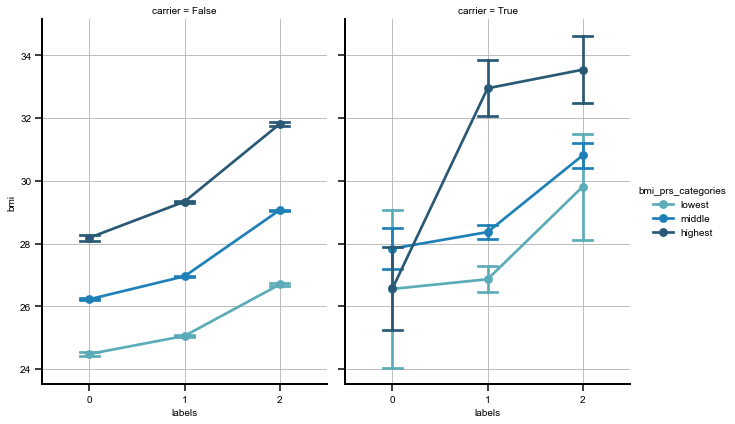

In [8]:
fig = utpl.create_variate_interaction_plot(phenotype_samples_info_mc4r_df)

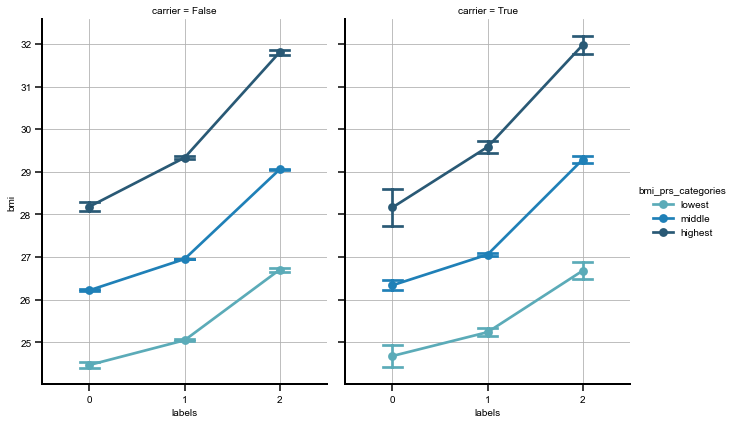

In [9]:
fig = utpl.create_variate_interaction_plot(phenotype_samples_info_all_df)

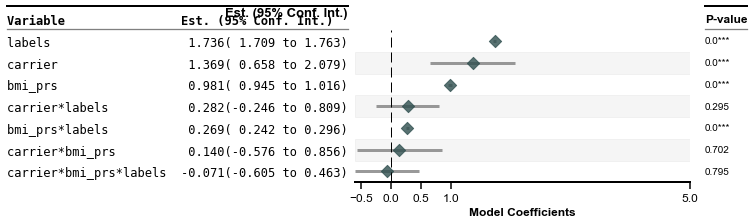

In [10]:
X_poly, y, poly_features = prepare_polynomial_features(phenotype_samples_info_mc4r_df, ["carrier", "bmi_prs", "labels"], "bmi", True)
r2, coefs, conf_ints, p_vals = train_model_sm(X_poly, y)
df_data = np.concatenate([poly_features.reshape(-1,1), coefs.reshape(-1,1), conf_ints, p_vals.reshape(-1,1)], axis=1)
coef_df = pd.DataFrame(df_data, columns=["variables", "coefs", "ci_low", "ci_high", "p_value"])
coef_df["variables"] = coef_df.variables.str.replace(" ", "*")
fig = utpl.create_variate_interaction_model_plot(coef_df)

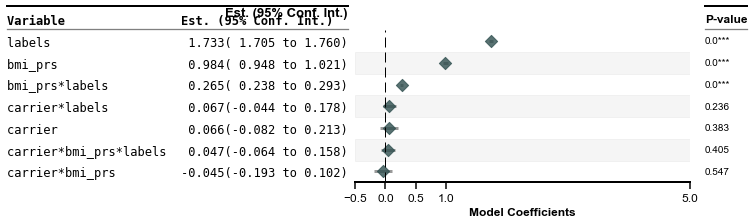

In [11]:
X_poly, y, poly_features = prepare_polynomial_features(phenotype_samples_info_all_df, ["carrier", "bmi_prs", "labels"], "bmi", True)
r2, coefs, conf_ints, p_vals = train_model_sm(X_poly, y)
df_data = np.concatenate([poly_features.reshape(-1,1), coefs.reshape(-1,1), conf_ints, p_vals.reshape(-1,1)], axis=1)
coef_df = pd.DataFrame(df_data, columns=["variables", "coefs", "ci_low", "ci_high", "p_value"])
coef_df["variables"] = coef_df.variables.str.replace(" ", "*")
fig = utpl.create_variate_interaction_model_plot(coef_df)

In [12]:
df = pd.read_csv("/data6/deepro/ukb_bmi/3_characterization/data/bmi_pgs_comorbidity/british/discovery/all_factors_bmi_info.csv")

In [15]:
df.loc[(df.labels==0)&(df.bmi_prs_categories=="lowest")].groupby("carrier").agg({"bmi": "mean", "sample_names": "count"})

,bmi,sample_names
carrier,,
False,24.428253,2920
True,27.427116,53


In [16]:
df.loc[(df.labels==2)&(df.bmi_prs_categories=="highest")].groupby("carrier").agg({"bmi": "mean", "sample_names": "count"})

,bmi,sample_names
carrier,,
False,31.656679,11757
True,36.123511,435


In [29]:
27.42-24.42, 36.12-31.65

(3.0, 4.469999999999999)

In [17]:
df.loc[(df.carrier==False)&(df.bmi_prs_categories=="lowest")].groupby("labels").agg({"bmi": "mean", "sample_names": "count"})

,bmi,sample_names
labels,,
0,24.428253,2920
1,24.997961,25767
2,26.600410,8328


In [18]:
df.loc[(df.carrier==True)&(df.bmi_prs_categories=="highest")].groupby("labels").agg({"bmi": "mean", "sample_names": "count"})

,bmi,sample_names
labels,,
0,33.238622,53
1,34.054308,591
2,36.123511,435


In [27]:
26.6-24.42, 36.12-33.23

(2.1799999999999997, 2.8900000000000006)

In [20]:
df.loc[(df.carrier==False)&(df.labels==0)].groupby("bmi_prs_categories").agg({"bmi": "mean", "sample_names": "count"})

,bmi,sample_names
bmi_prs_categories,,
highest,28.061215,2221
lowest,24.428253,2920
middle,26.160632,20477


In [21]:
df.loc[(df.carrier==True)&(df.labels==2)].groupby("bmi_prs_categories").agg({"bmi": "mean", "sample_names": "count"})

,bmi,sample_names
bmi_prs_categories,,
highest,36.123511,435
lowest,29.948081,260
middle,32.791009,2457


In [25]:
36.12-29.9, 28.06-24.42

(6.219999999999999, 3.639999999999997)

In [26]:
36.12-24.42

11.699999999999996

In [30]:
df = pd.read_csv("/data6/deepro/ukb_bmi/0_data_preparation_and_download/phenotype/data/bmi_processed/british/train_cohort_bmi.csv.gz")
